# Example functions

This notebook shows how to use the functions to build QUBO models for disordered materials.

In [106]:
from QG_functions import *

import numpy as np
import pandas as pd

from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.core.periodic_table import Element
from pymatgen.io.cif import *

from ase.visualize import view


from pymatgen.io.ase import AseAtomsAdaptor
import sys

import re
import shutil as sh
import pickle
from tqdm import tqdm


import copy
from sklearn.metrics import mean_squared_error 

#import dataframe_image as dfi

from scipy import constants
from scipy.spatial import KDTree, distance_matrix

import matplotlib.pyplot as plt

import itertools
from itertools import chain

from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error as mse


k_b = constants.physical_constants['Boltzmann constant in eV/K'][0]
# print(k_b)
def vview(structure):
    view(AseAtomsAdaptor().get_atoms(structure))

np.seterr(divide='ignore')
plt.style.use('tableau-colorblind10')

import seaborn as sns
import time

## Discrete QUBO matrix

In [107]:
CaF2 = Structure.from_file('data/structures/CaF2.cif')
CaF2_charges = []
for site in CaF2:
    CaF2_charges.append(site.as_dict()['species'][0]['oxidation_state'])
CaF2 = Structure(CaF2.lattice,CaF2.atomic_numbers,CaF2.frac_coords) # To avoid having the species called Ca0, Ca1 etc...

In [108]:
CaF2

Structure Summary
Lattice
    abc : 5.51605194 5.51605194 5.51605194
 angles : 90.0 90.0 90.0
 volume : 167.83596915985262
      A : np.float64(5.51605194) np.float64(0.0) np.float64(3.377607676125774e-16)
      B : np.float64(-3.377607676125774e-16) np.float64(5.51605194) np.float64(3.377607676125774e-16)
      C : np.float64(0.0) np.float64(0.0) np.float64(5.51605194)
    pbc : True True True
PeriodicSite: Ca (0.0, 0.0, 0.0) [0.0, 0.0, 0.0]
PeriodicSite: Ca (-1.689e-16, 2.758, 2.758) [0.0, 0.5, 0.5]
PeriodicSite: Ca (2.758, 0.0, 2.758) [0.5, 0.0, 0.5]
PeriodicSite: Ca (2.758, 2.758, 3.378e-16) [0.5, 0.5, 0.0]
PeriodicSite: F (1.379, 4.137, 1.379) [0.25, 0.75, 0.25]
PeriodicSite: F (1.379, 4.137, 4.137) [0.25, 0.75, 0.75]
PeriodicSite: F (1.379, 1.379, 4.137) [0.25, 0.25, 0.75]
PeriodicSite: F (1.379, 1.379, 1.379) [0.25, 0.25, 0.25]
PeriodicSite: F (4.137, 4.137, 4.137) [0.75, 0.75, 0.75]
PeriodicSite: F (4.137, 4.137, 1.379) [0.75, 0.75, 0.25]
PeriodicSite: F (4.137, 1.379, 1.379) [

### Build the initial Ewald matrix for one of the end members
This is a NxN matrix. All charges are 1. I only need to calculate this once because the values are the same since it is a fixed lattice.

In [109]:
ewald_matrix = compute_ewald_matrix(CaF2,triu=True)

Computing real space: 100%|██████████| 12/12 [00:00<00:00, 12.05it/s]


### Build the discrete Ewald matrix with charges
This is a "larger than" NxN matrix, the actual size depends on how many sites have fractional occupancy. The charges are the ones from the real material. 

In [110]:
structure = CaF2
sites_frac_occupancy = [[0,1,2,3]]
charges = {
    20: [2,1],
    9: [-1]
}

ewald_discrete, expanded_charges, expanded_matrix = compute_discrete_ewald_matrix(structure, charges, ewald_matrix=ewald_matrix)


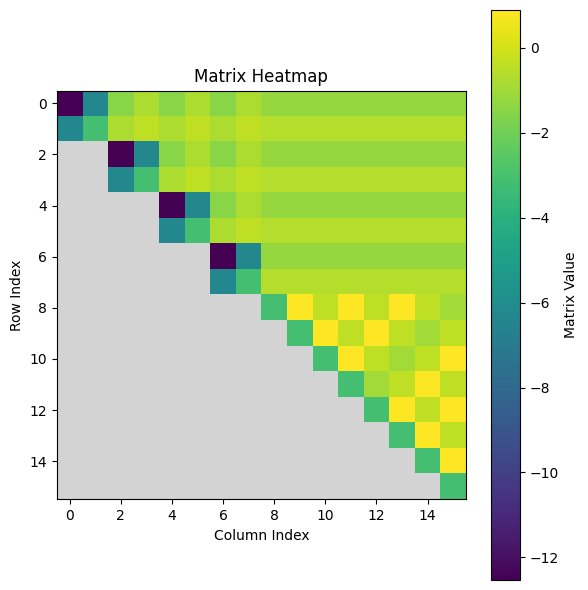

In [111]:
plot_matrix_heatmap(ewald_discrete)

### Build the discrete Buckingham matrix
This is a "larger than" NxN matrix, the actual size depends on how many sites have fractional occupancy. 

In [112]:
species_dict = {'Ca': ['Ca', 'Mg']}  # Ca sites can be either Ca (20) or Sc (21)
buckingham_dict = {'Mg-F':    [821.6,    0.3242 ,  0.0] ,    
'Ca-F':    [1293.6,   0.2990,   0.0] ,    
'F-F':    [22764.0,  0.1490,  27.88]   }
buckingham_matrix, species_vector = compute_buckingham_matrix_discrete(
    structure, species_dict, buckingham_dict, R_max=25.0
)

Buckingham matrix: 100%|██████████| 12/12 [00:00<00:00, 21.29it/s]


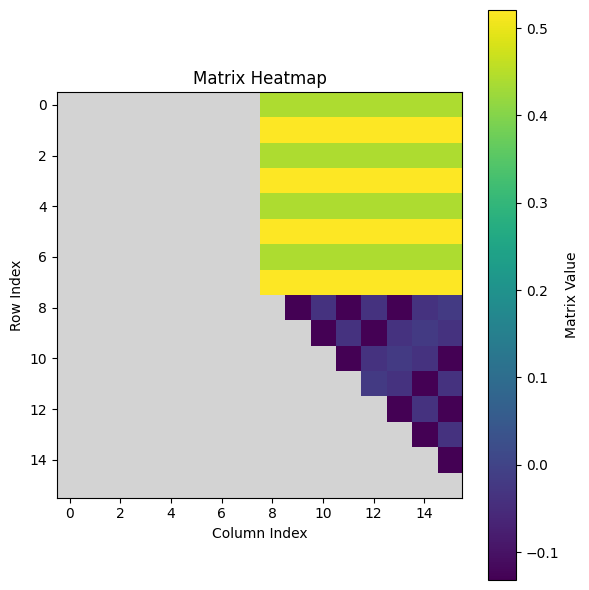

In [113]:
plot_matrix_heatmap(buckingham_matrix)

## Reduce the matrix size: Domain Wall Encoding

In [ ]:
species_vector
fixed_species = [9]
frac_occupancy_species = {20:[20,12]} #Ca is the zero refrence

def build_qubo_discrete_from_Ewald_IP(ewald_discrete,buckingham_matrix):
    Q = ewald_discrete + buckingham_matrix

    return Q

def reduce_qubo_discrete(Q_discrete,structure,species_vector,frac_occupancy_species,fixed_species):
    
    print(species_vector)
    an_vector_discrete = np.array([Element(sym).Z for sym in species_vector])
    an_vector = np.array(structure.atomic_numbers)
    num_sites = structure.num_sites
    
    Q = np.zeros((num_sites,num_sites))
    zero_energy = 0
    pos_fixed = []
    for fs in fixed_species:
        pos_fixed.extend(np.where(an_vector_discrete == fs)[0])
    pos_fixed = np.array(pos_fixed)
    
    zero_energy = 0
    
    for species1 in frac_occupancy_species.keys():
        pos_discrete = np.where(an_vector_discrete == species1)[0]
        pos = np.where(an_vector == species1)[0]
        
        for p1,i in enumerate(pos):

            Q[i,i] += Q_discrete[pos_discrete[i]+1,pos_discrete[i]+1] - Q_discrete[pos_discrete[i],pos_discrete[i]] #E_Ca - E_Mg
            # print(pos_discrete[i]+1,pos_discrete[i],Q_discrete[pos_discrete[i]+1,pos_discrete[i]+1] - Q_discrete[pos_discrete[i],pos_discrete[i]])
            zero_energy += Q_discrete[pos_discrete[i],pos_discrete[i]]
            
            for p2,j in enumerate(pos):
                if j>i:
                    print('The line below: I think I need the CaMg interaction from all')
                    Q[i,i] += Q_discrete[pos_discrete[i],pos_discrete[j]+1] #E_CaMg to the diagonal

                    Q[i,j] += Q_discrete[pos_discrete[i]+1,pos_discrete[j]+1] - Q_discrete[pos_discrete[i],pos_discrete[j]+1] #E_MgMg - E_CaMg
                    zero_energy += Q_discrete[pos_discrete[i],pos_discrete[j]] #E_CaCa
                    # print(i,j,'   ',pos_discrete[i],pos_discrete[j]+1,Q_discrete[pos_discrete[i],pos_discrete[j]+1])
                    # print(i,j,'   ',pos_discrete[i],pos_discrete[j]+1,Q_discrete[pos_discrete[i]+1,pos_discrete[j]+1] - Q_discrete[pos_discrete[i],pos_discrete[j]+1])
            for p3,k in enumerate(pos_fixed):
                # print(i,pos_discrete[i]+1,k,'   ', pos_discrete[i]+1)

                Q[i,i] += Q_discrete[pos_discrete[i]+1,k] #E_MgF
                zero_energy += Q_discrete[pos_discrete[i],k] #E_CaF
    
                

    return Q
Q = build_qubo_discrete_from_Ewald_IP(ewald_discrete,buckingham_matrix)
reduce_qubo_discrete(Q,structure,species_vector,frac_occupancy_species,fixed_species)[0:4,0:4]

['Ca', 'Mg', 'Ca', 'Mg', 'Ca', 'Mg', 'Ca', 'Mg', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F']
The line below: I think I need the CaMg interaction from all
The line below: I think I need the CaMg interaction from all
The line below: I think I need the CaMg interaction from all
The line below: I think I need the CaMg interaction from all
The line below: I think I need the CaMg interaction from all
The line below: I think I need the CaMg interaction from all


array([[6.34774185, 0.3804313 , 0.3804313 , 0.3804313 ],
       [0.        , 7.1085992 , 0.3804313 , 0.3804313 ],
       [0.        , 0.        , 7.86946181, 0.3804313 ],
       [0.        , 0.        , 0.        , 8.63032441]])

In [ ]:
species_vector
fixed_species = ['F']
frac_occupancy_species = {'Ca':['Ca','Mg']} #Ca is the zero refrence

def build_qubo_discrete_from_Ewald_IP(ewald_discrete,buckingham_matrix):
    Q = ewald_discrete + buckingham_matrix

    return Q

def reduce_qubo_discrete(Q_discrete,structure,species_vector,frac_occupancy_species,fixed_species):
    
    print(species_vector)
    an_vector = np.array([Element(sym).Z for sym in species_vector])
    num_sites = structure.num_sites
    
    Q = np.zeros((num_sites,num_sites))
    zero_energy = 0
    for species1 in frac_occupancy_species.keys():
        for i,site1 in enumerate(species_vector):
            if site1 == species1:
                for j,site2 in enumerate(species_vector):
                    if i == j:
                        Q[i,i] = Q_discrete[i+1,i+1] - Q_discrete[i,i] #E_Ca - E_Mg
                        zero_energy += Q_discrete[i,i]
                    elif j > i:
                        if site2 == species1:
                            Q[i,j] = Q_discrete[i+1,i+1] - Q_discrete[i,i]

                

    return Q
Q = build_qubo_discrete_from_Ewald_IP(ewald_discrete,buckingham_matrix)
reduce_qubo_discrete(Q,structure,species_vector,frac_occupancy_species,fixed_species)

['Ca', 'Mg', 'Ca', 'Mg', 'Ca', 'Mg', 'Ca', 'Mg', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F']


array([[9.39977993, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 9.39977993, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 9.39977993,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ,

In [115]:
an_vector = np.array([Element(sym).Z for sym in species_vector])

In [118]:
an_vector

array([20, 12, 20, 12, 20, 12, 20, 12,  9,  9,  9,  9,  9,  9,  9,  9])